<a href="https://colab.research.google.com/github/rishiiiiitaaaaa/Nucleus_training_assignments/blob/main/machine_learning/assignment01/b2_b3/ML_partb2_b3_regression_boston.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part A (done as per requirements)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# 1) Load dataset

boston = fetch_openml(name="boston", version=1, as_frame=True)
df = boston.frame.copy()   # contains MEDV target

print("Initial shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nInitial dtypes (first 10):")
print(df.dtypes.head(10))


Initial shape: (506, 14)

Column names: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

Initial dtypes (first 10):
CRIM      float64
ZN        float64
INDUS     float64
CHAS     category
NOX       float64
RM        float64
AGE       float64
DIS       float64
RAD      category
TAX       float64
dtype: object



Summary statistics
             CRIM          ZN       INDUS         NOX          RM         AGE  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.554695    6.284634   68.574901   
std      8.601545   23.322453    6.860353    0.115878    0.702617   28.148861   
min      0.006320    0.000000    0.460000    0.385000    3.561000    2.900000   
25%      0.082045    0.000000    5.190000    0.449000    5.885500   45.025000   
50%      0.256510    0.000000    9.690000    0.538000    6.208500   77.500000   
75%      3.677083   12.500000   18.100000    0.624000    6.623500   94.075000   
max     88.976200  100.000000   27.740000    0.871000    8.780000  100.000000   

              DIS         TAX     PTRATIO           B       LSTAT        MEDV  
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000  
mean     3.795043  408.237154   18.455534  356.674032   12.653063   22.532806  
std      2

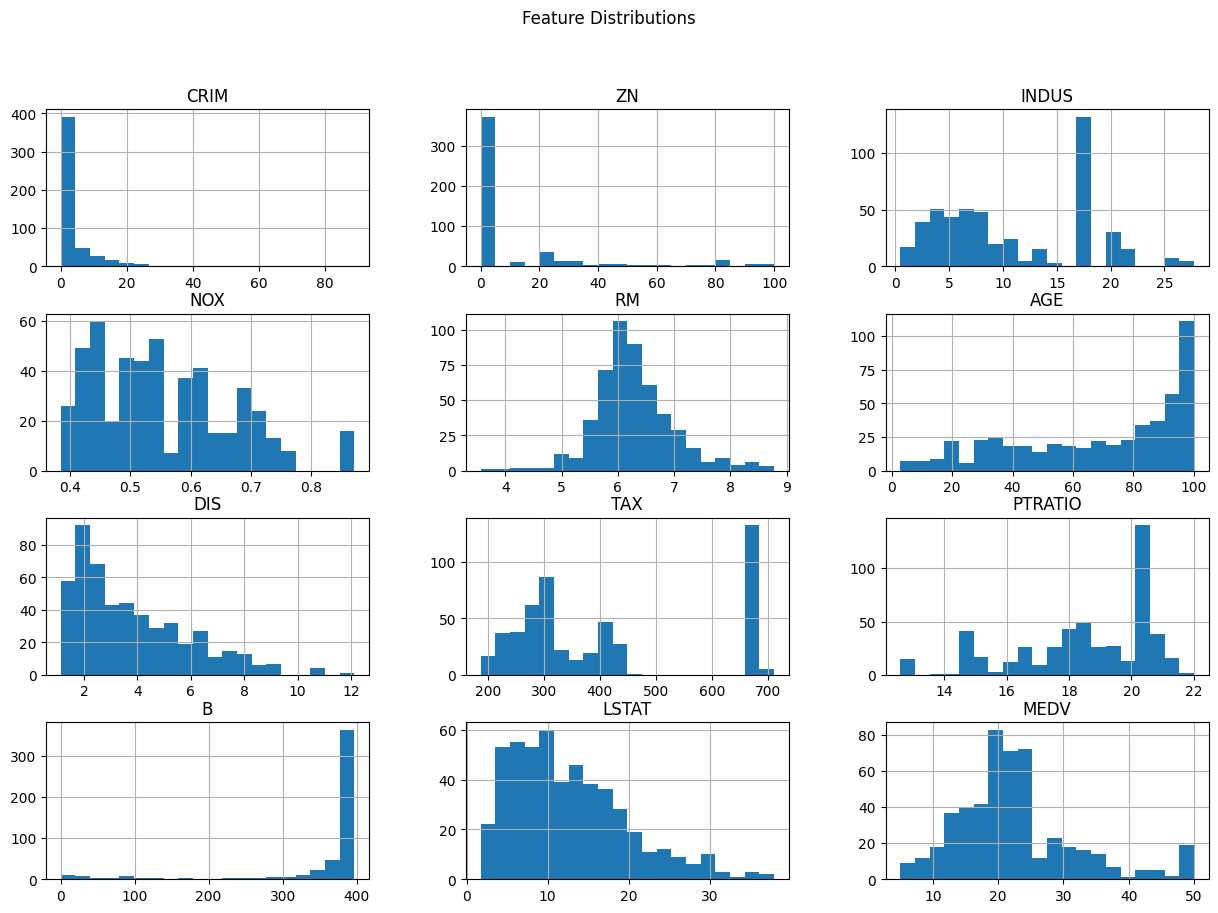

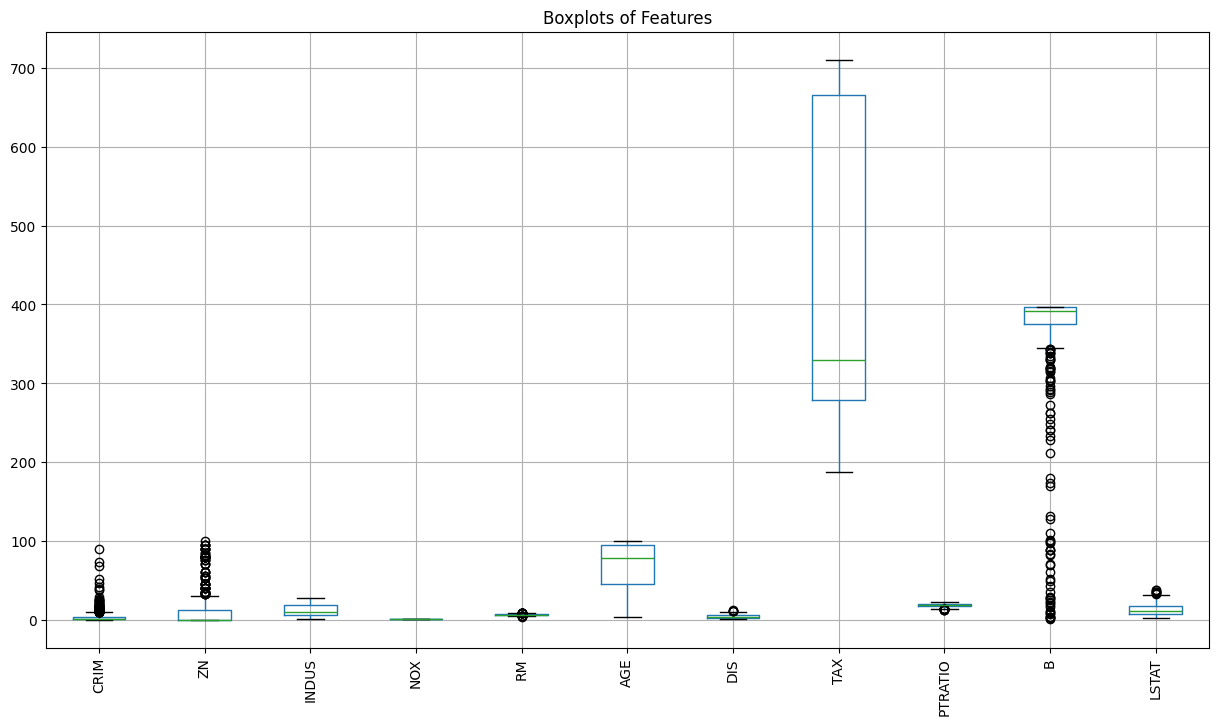

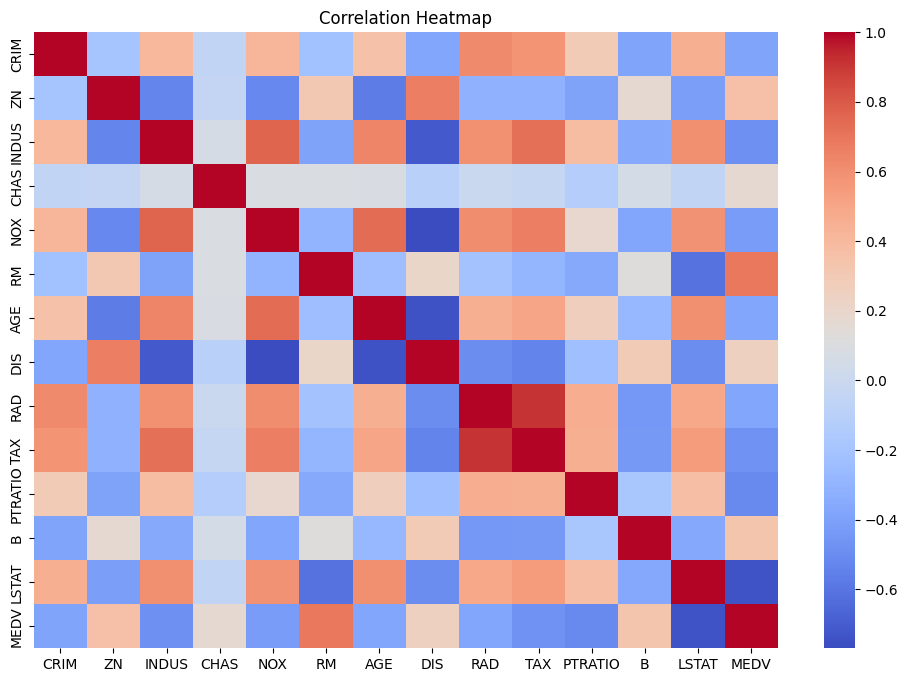

In [2]:
# A1: Exploratory Data Analysis
print("\nSummary statistics")
print(df.describe())

# Histograms
df.hist(bins=20, figsize=(15, 10))
plt.suptitle("Feature Distributions")
plt.show()

# Boxplots
plt.figure(figsize=(15, 8))
df.drop(columns="MEDV").boxplot(rot=90)
plt.title("Boxplots of Features")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [3]:
# A2: Data Understanding

print("\nMissing values per column:")
print(df.isnull().sum())

dup_count = df.duplicated().sum()
print(f"\nDuplicate rows: {dup_count}")

# Quick outlier count using IQR
iqr_outlier_counts = {}
num_cols = df.drop(columns="MEDV").select_dtypes(include=np.number).columns
for c in num_cols:
    Q1, Q3 = df[c].quantile(0.25), df[c].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    iqr_outlier_counts[c] = ((df[c] < lower) | (df[c] > upper)).sum()

print("\nOutlier counts per numeric column:")
print(iqr_outlier_counts)



Missing values per column:
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Duplicate rows: 0

Outlier counts per numeric column:
{'CRIM': np.int64(66), 'ZN': np.int64(68), 'INDUS': np.int64(0), 'NOX': np.int64(0), 'RM': np.int64(30), 'AGE': np.int64(0), 'DIS': np.int64(5), 'TAX': np.int64(0), 'PTRATIO': np.int64(15), 'B': np.int64(77), 'LSTAT': np.int64(7)}


In [4]:
# A3: Data Cleaning
df = df.drop_duplicates()
df_numeric = df.apply(pd.to_numeric, errors='coerce')
df_numeric = df_numeric.fillna(df_numeric.median(numeric_only=True))


In [5]:
# A4: Feature Transformation
scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(df_numeric.drop(columns="MEDV"))


In [6]:
# A5: Feature Creation

df_numeric["LSTAT*RM"] = df_numeric["LSTAT"] * df_numeric["RM"]   # interaction feature
df_numeric["AGE_BIN"] = pd.cut(df_numeric["AGE"], bins=[0,35,70,100], labels=["Young","Middle","Old"])

# Encode AGE_BIN
df_numeric = pd.get_dummies(df_numeric, columns=["AGE_BIN"], drop_first=True)


In [7]:
# A6: Feature Selection

# 1) Correlation filter
corr_matrix = df_numeric.corr()
top_corr_features = corr_matrix["MEDV"].abs().sort_values(ascending=False).head(10)
print("\nTop correlated features with MEDV:")
print(top_corr_features)

# 2) Feature importance (Random Forest)
X_temp = df_numeric.drop(columns="MEDV")
y_temp = df_numeric["MEDV"]
rf = RandomForestRegressor(random_state=42)
rf.fit(X_temp, y_temp)
feat_importances = pd.Series(rf.feature_importances_, index=X_temp.columns).sort_values(ascending=False).head(10)
print("\nTop 10 features by RandomForest importance:")
print(feat_importances)



Top correlated features with MEDV:
MEDV        1.000000
LSTAT       0.737663
LSTAT*RM    0.729524
RM          0.695360
PTRATIO     0.507787
INDUS       0.483725
TAX         0.468536
NOX         0.427321
CRIM        0.388305
RAD         0.381626
Name: MEDV, dtype: float64

Top 10 features by RandomForest importance:
LSTAT       0.399371
RM          0.362483
DIS         0.061377
LSTAT*RM    0.056761
CRIM        0.033638
NOX         0.020089
PTRATIO     0.015490
AGE         0.013296
TAX         0.012617
B           0.009907
dtype: float64


#B2:Regression

In [8]:
# 1) Train/test split

target_col = "MEDV"
X = df_numeric.drop(columns=[target_col])
y = df_numeric[target_col].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale only for SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)



Train shape: (404, 16) Test shape: (102, 16)


In [9]:
# Helper functions

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_model(name, model, X_train_in, y_train_in, X_test_in, y_test_in, plot=True):
    Xtr = np.asarray(X_train_in, dtype=np.float64)
    Xt = np.asarray(X_test_in, dtype=np.float64)
    ytr = np.asarray(y_train_in, dtype=np.float64)
    yt = np.asarray(y_test_in, dtype=np.float64)

    model.fit(Xtr, ytr)
    y_pred = model.predict(Xt)

    metrics = {
        "Model": name,
        "MAE": mean_absolute_error(yt, y_pred),
        "MSE": mean_squared_error(yt, y_pred),
        "RMSE": rmse(yt, y_pred),
        "R2": r2_score(yt, y_pred)
    }

    if plot:
        plt.figure(figsize=(5,5))
        sns.scatterplot(x=yt, y=y_pred, alpha=0.6)
        mn, mx = min(yt.min(), y_pred.min()), max(yt.max(), y_pred.max())
        plt.plot([mn,mx],[mn,mx],"--", color="red")
        plt.xlabel("Actual MEDV")
        plt.ylabel("Predicted MEDV")
        plt.title(f"{name} — Predicted vs Actual")
        plt.tight_layout()
        plt.show()

    return metrics
#used in comparision
results = []

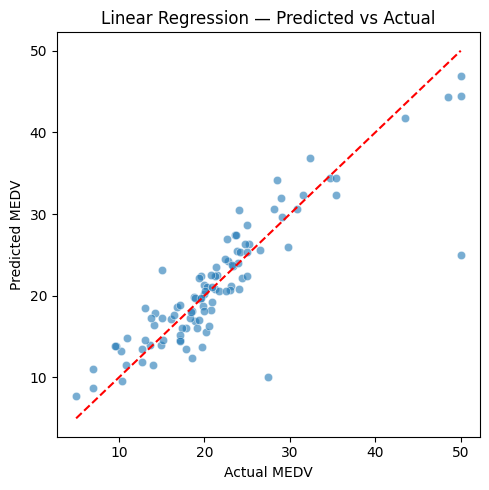

In [10]:
# Train model
# Linear Regression
# Baseline model with no hyperparameters.
# Good starting point for regression tasks.

lin = LinearRegression()
results.append(
    evaluate_model("Linear Regression", lin, X_train, y_train, X_test, y_test)
)

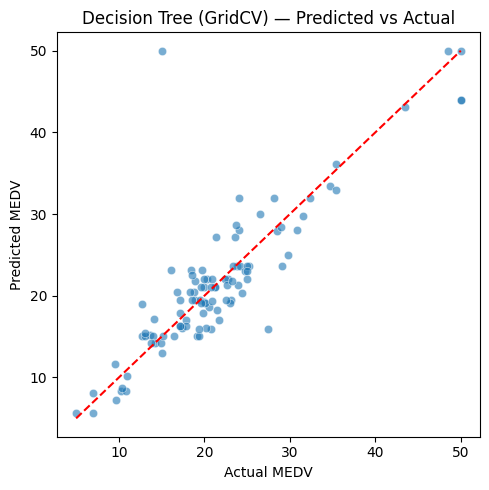

In [11]:
# Decision Tree Regressor (with GridSearchCV)
# Hyperparameter tuning:
# - max_depth controls tree depth (avoid overfitting).
# - min_samples_split prevents tiny splits.
# GridSearchCV helps find the best combination.

dt_param_grid = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 5, 10]
}

dt_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    dt_param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

results.append(
    evaluate_model("Decision Tree (GridCV)", dt_grid, X_train, y_train, X_test, y_test)
)


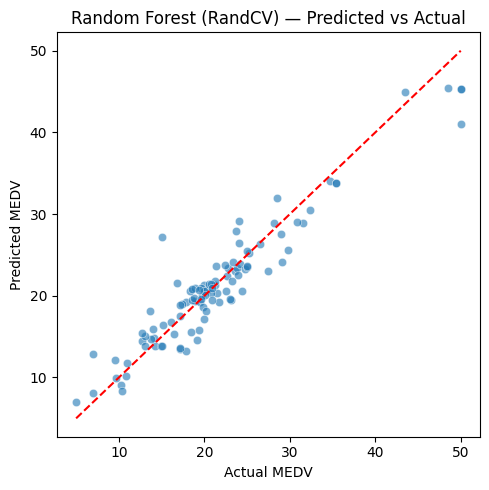

In [12]:
# Random Forest Regressor (RandomizedSearchCV)
# Uses multiple decision trees and averages results.
# RandomizedSearchCV speeds up tuning compared to full grid search.

rf_param_dist = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10]
}

rf_rand = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    rf_param_dist,
    n_iter=8,
    cv=3,
    scoring="r2",
    random_state=42,
    n_jobs=-1
)

results.append(
    evaluate_model("Random Forest (RandCV)", rf_rand, X_train, y_train, X_test, y_test)
)


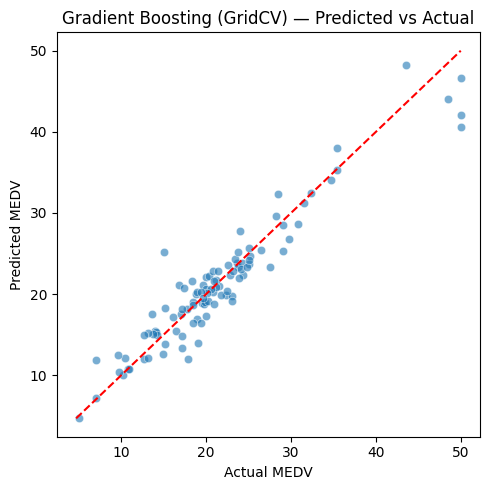

In [13]:
# Gradient Boosting Regressor (GridSearchCV)
# Boosting builds trees sequentially, correcting errors of previous trees.
# Tuning learning_rate and n_estimators is critical.

gb_param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 5]
}

gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1
)

results.append(
    evaluate_model("Gradient Boosting (GridCV)", gb_grid, X_train, y_train, X_test, y_test)
)


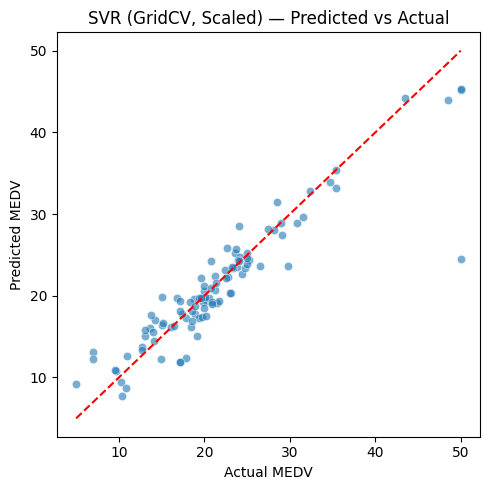

In [14]:
# Support Vector Regressor (GridSearchCV)
# SVR requires scaled features for good performance.
# Kernel trick allows nonlinear relationships.

svr_param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", "auto"],
    "kernel": ["rbf", "linear"]
}

svr_grid = GridSearchCV(
    SVR(),
    svr_param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1
)

results.append(
    evaluate_model("SVR (GridCV, Scaled)", svr_grid, X_train_scaled, y_train, X_test_scaled, y_test)
)


In [15]:
# Results

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="R2", ascending=False).reset_index(drop=True)

print("\nModel comparison (sorted by R2)")
print(results_df)


Model comparison (sorted by R2)
                        Model       MAE        MSE      RMSE        R2
0  Gradient Boosting (GridCV)  1.885761   7.055535  2.656226  0.903789
1      Random Forest (RandCV)  1.981452   7.459106  2.731136  0.898286
2        SVR (GridCV, Scaled)  2.023152  11.978792  3.461039  0.836654
3           Linear Regression  2.592254  16.632816  4.078335  0.773190
4      Decision Tree (GridCV)  2.630178  21.144453  4.598310  0.711668


# B3: Model Explainability (SHAP)



Best model based on R²: Gradient Boosting (GridCV)


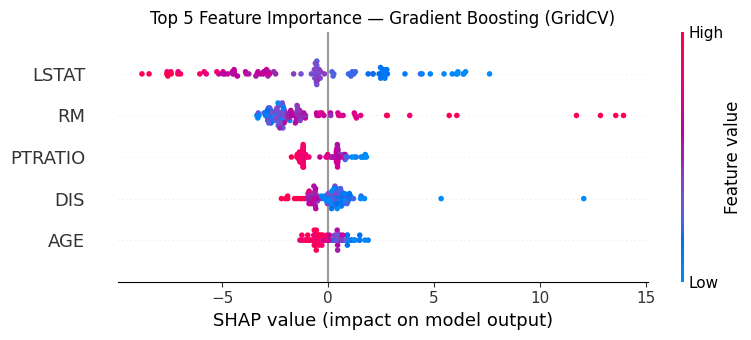

In [21]:
# 1. Import SHAP
import shap

# 2. Identify Best Model (based on R² from results_df)
best_model_name = results_df.iloc[0]["Model"]
print(f"\nBest model based on R²: {best_model_name}")

# 3. Select the trained best model object + appropriate SHAP explainer
if "Linear Regression" in best_model_name:
    best_model = lin
    explainer = shap.Explainer(best_model, X_train)
    X_sample = X_test.sample(100, random_state=42)   # use small subset for speed

elif "Decision Tree" in best_model_name:
    best_model = dt_grid.best_estimator_
    explainer = shap.TreeExplainer(best_model)
    X_sample = X_test.sample(100, random_state=42)

elif "Random Forest" in best_model_name:
    best_model = rf_rand.best_estimator_
    explainer = shap.TreeExplainer(best_model)
    X_sample = X_test.sample(100, random_state=42)

elif "Gradient Boosting" in best_model_name:
    best_model = gb_grid.best_estimator_
    explainer = shap.TreeExplainer(best_model)
    X_sample = X_test.sample(100, random_state=42)

elif "SVR" in best_model_name:
    best_model = svr_grid.best_estimator_
    explainer = shap.KernelExplainer(best_model.predict, shap.sample(X_train_scaled, 100))
    X_sample = shap.sample(X_test_scaled, 100, random_state=42)

else:
    raise ValueError("No matching best model found for SHAP explanation.")


# 4. Compute SHAP values
if "SVR" in best_model_name:
    shap_values = explainer(X_sample)   # for KernelExplainer (SVR)
else:
    shap_values = explainer(X_sample)   # modern API returns Explanation objects


# 5. SHAP Summary Plot (global feature importance)
plt.title(f"Top 5 Feature Importance — {best_model_name}")
shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=X_train.columns,
    max_display=5,
    show=True
)

